Desarrollar un método computacional que, a partir de una img (y opcionalmente su máscara
de recorte), permita:
Identificar las imágenes que pertenecen a las categorı́as : “elephant” y “rhino”.
Proporcionar una evaluación cuantitativa adecuada de la identificaciones correspondientes

Es decir, clasificar cada img, considerando caracterı́sticas integradas para toda la img, región recortada y/o contorno, entre, por ejemplo, clase objetivo y resto

In [ ]:
import cv2
from matplotlib import pyplot as plt
from random import sample

Primero cargaremos las imagenes y las etiquetas. Como queremos diferenciar entre elefantes y rinocerontes, no nos vale la pena esforzarnos en distinguir si es un emu o un flamenco, entonces todo lo que no nos interese sera 'otros'. En una primera instancia no considereremos las máscaras de esta forma $X$ serán todas las imágenes e $Y$ sera la etiqueta asociada de entre {'rinoceronte', 'elefante', 'otros'}.

In [ ]:
import glob
import skimage.io as io
import skimage.transform as tr
import matplotlib.pyplot as plt
import numpy as np

elefante = glob.glob("../objects/images/elephant/*.jpg") # rutas
rino = glob.glob("../objects/images/rhino/*.jpg")
emu = glob.glob("../objects/images/emu/*.jpg")
flamingo = glob.glob("../objects/images/flamingo/*.jpg")
otros = [*emu, *flamingo]

elefante = [io.imread(i) for i in elefante] #imageneoos
rino = [io.imread(i) for i in rino]
otros = [io.imread(i) for i in otros]


plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(elefante[0])
plt.title("elefante")
plt.axis("off")

plt.subplot(132)
plt.imshow(rino[0])
plt.title("rino")
plt.axis("off")

plt.subplot(133)
plt.imshow(otros[0])
plt.title("otros")
plt.axis("off")

plt.show()

In [ ]:
mascaraElefante = glob.glob("../objects/masks/elephant/*.png")
mascaraElefante = [io.imread(i) for i in mascaraElefante]

In [ ]:
mascaraElefante[0] = tr.resize(mascaraElefante[0],(elefante[0].shape[0],elefante[0].shape[1]))

In [ ]:
capa = np.array(mascaraElefante[0] > 0.5,dtype=np.uint8)

In [ ]:
capa = [[[capa[i][j],capa[i][j],capa[i][j]] for j in range(capa.shape[1])] for i in range(capa.shape[0])]

In [ ]:
capa;

In [ ]:
#np.multiply(capa,elefante[0])
verdad = np.resizenp.array(mascaraElefante[0] > 0.5,dtype=np.uint8)
for i in range(elefante[0].shape)

In [ ]:
elefante[0][] = 0

In [ ]:
elefante[0].shape, mascaraElefante[0].shape

In [ ]:
plt.imshow(elefante[0])

In [ ]:
# primero cargaremos las imagenes, las etiquetas y eventualmente las máscaras
# como queremos diferenciar entre elefantes y rinocerontes, no nos vale la pena esforzarnos
# en distinguir si es un emu o un flamenco, entonces todo lo que no nos interese sera 'otros'

# en una primera instancia no considereremos las máscaras
# de esta forma X serán todas las imágenes e Y sera la etiqueta asociada

In [ ]:
# ahora armamos X e Y

X = [*elefante, *rino, *otros]
Y =  [*['elefante']*len(elefante), *['rino']*len(rino), *['otros']*len(otros)]

In [ ]:
# como hay imagenes en blanco y negro y en color, y eso supone diferencias de tamaño, voy a 
# tridimensionalizar las imagenes en blanco y negro. Triplicando la información que contienen.

def Tridimensionaliza(imagen):
    return np.array([[[imagen[i][j],imagen[i][j],imagen[i][j]] for i in range(np.shape(imagen)[0])] for j in range(np.shape(imagen)[1])])

# ademas, pasamos todos los elementos de X a arrays de numpy
X = [np.array(imagen) if len(np.shape(imagen)) == 3  else Tridimensionaliza(imagen) for imagen in X ] 

In [ ]:
# (como simple demostracion de que lo anterior es correcto..
from random import randint as r

indice = r(0,len(X))

plt.imshow(X[indice])
plt.title(Y[indice])
plt.show()
# ...si al ejecutar, el titulo se corresponde con la imagen es que X e Y estan construidos segun nuestro deseo)

In [ ]:
from math import ceil as techo
from random import shuffle as s

# Como cada imagen mide distinto las hacemos todas iguales. Además, las aplanamos

X = [np.array(tr.resize(i,(300,200))).flatten() for i in X]

# Para que nuestras conclusiones sean rigurosas, debemos O usar el error de validación O usar
# una partición de los datos en Entrenamiento y Test. Prodemos con la opción de test


# primero tendremos que desordenarlas, porque si le pasamos solo el final, tendra
# que clasificar exclusivamente 'otros' lo cual no nos interesa

temp = list(zip(X, Y))
s(temp)
X, Y = zip(*temp)


X_entrenamiento = X[:techo(len(X)*.8) ]
X_test =          X[ techo(len(X)*.8):]
Y_entrenamiento = Y[:techo(len(X)*.8) ]
Y_test =          Y[ techo(len(X)*.8):]

## Momento de entrenar

Como en el enunciado de la práctica no se entra en detalle de que algoritmo usar... lo científico por nuestra parte es probar los que nos _tengan sentido_ y ver cual da mejor resultado. Como primer intento, probaremos con KNN...

## Primer intento, sin mascaras con KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# que k usamos? vamos a ver cuantos datos tenemos
#
# $ print(f'hay {len(elefante)} elefantes y {len(rino)} rinocerontes')
# -> hay 64 elefantes y 59 rinocerontes
#
# usaremos un K de entorno a 50, por tanto (prepiero que descuide algunos 
# de su misma clase que que considere algunos de otras clases)

knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = knn.predict(X_test)
print(classification_report(Y_predicho,Y_test))

In [ ]:
# Malos resultados, pero curiosamente donde mejores resultados
# hubo fue en 'otros'. Vamos a probar a repetir todo pero sin 'otros'

## Segundo intento, sin mascaras con KNN y sin _otros_

In [ ]:
X = [*elefante, *rino]
Y =  [*['elefante']*len(elefante), *['rino']*len(rino)]

temp = list(zip(X, Y))
s(temp)
X, Y = zip(*temp)


X = [np.array(imagen) if len(np.shape(imagen)) == 3  else Tridimensionaliza(imagen) for imagen in X ] 

X = [np.array(tr.resize(i,(300,200))).flatten() for i in X]

X_entrenamiento = X[:techo(len(X)*.8) ]
X_test =          X[ techo(len(X)*.8):]
Y_entrenamiento = Y[:techo(len(X)*.8) ]
Y_test =          Y[ techo(len(X)*.8):]

knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = knn.predict(X_test)
print(classification_report(Y_predicho,Y_test))

Observamos una mejora en los resultados, pero porque ahora la tarea es mucho más sencilla. Un modelo que no sepa nada acertaria en la mitad de las ocasiones.

In [ ]:

# recomendación joaquim 
# pintar matriz confusionb

# EJERCICIO 2
# Clasificación de Imágenes

## Librerías

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from random import sample
from random import shuffle
from math import ceil as techo
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

## Funciones

In [32]:
def CargaDatos(rutaObjects,verbose=False):
    def ordenaDirectorio(directorio, extension="jpg"):
        return sorted([os.path.join(directorio, f) for f in os.listdir(directorio) if f.endswith(extension)])
    animales = ['elephant', 'emu', 'flamingo', 'rhino']
    
    datos = {}
    for animal in animales:
        datos[animal] = ordenaDirectorio(f"{rutaObjects}/images/{animal}", extension="jpg"), ordenaDirectorio(f"{rutaObjects}/masks/{animal}", extension="png")

    print('Cargando datos...')
    if verbose:
        for animal in datos:
            print(f'\nAnimal: {animal}')
            for imagen, mascara in zip(datos[animal][0], datos[animal][1]):
                print(f"Imagen: {os.path.basename(imagen)}, Máscara: {os.path.basename(mascara)}")
    return datos
#####################
def recortadoAleatorio(pixeles, minimo):
    indices = sorted(sample(range(len(pixeles)),minimo))
    return np.array([pixeles[indice] for indice in indices]).flatten()
####################
def desordena(X,Y):
    temp = list(zip(X, Y))
    shuffle(temp)
    return zip(*temp)
    

#########################
def procesaImagen(imagen, mascara,numPixeles):
    def haz_histograma(pixeles):
        return np.array([np.histogram(pixelesEnMascara[:,color],bins=np.arange(256))[0] for color in range(3)]).flatten(order='F')
    
    imagen = cv2.imread(imagen)
    imagen = cv2.resize(imagen, (tamano[1],tamano[0])) # si lo pongo tal cual y luego hago imagen.shape devuelve (300, 200)

    mascara = cv2.imread(mascara, cv2.IMREAD_GRAYSCALE)
    mascara = cv2.resize(mascara, (tamano[1],tamano[0]))
        
    mascaraBinaria = mascara = (mascara > 0).astype(bool)  # Binarizar la máscara
    
    #imagen = cv2.Sobel(imagen, -1,1,0,ksize=3)    MALOS RESULTADOS   
    imagen = cv2.GaussianBlur(255 - imagen, (0, 0), 2, 2)
    
    pixelesEnMascara = np.reshape(np.array([np.array(imagen[i][j]) for i in range(tamano[0]) for j in range(tamano[1]) if mascaraBinaria[i][j]]),(sum(sum(mascaraBinaria)),3))
    histograma = haz_histograma(pixelesEnMascara)
    algunosPixeles = recortadoAleatorio(pixelesEnMascara,numPixeles)
   
    if numPixeles:
        return [*histograma, *algunosPixeles]
    else:
        return [*histograma]
###########################
def construyeDataset(datos,numPixeles, balancear=True):
    
    X = []
    Y = []
    factorMultiplicativo = 1

    print('Procesando datos...')
    for i in range(factorMultiplicativo):
        for animal in datos:
            print(f'\nAnimal: {animal}')
            for imagen, mascara in zip(datos[animal][0], datos[animal][1]):
                # Cargar y redimensionar imagen
                
                X.append(procesaImagen(imagen, mascara,numPixeles))

                if animal == 'elephant':
                    Y.append('E')
                elif animal == 'rhino':
                    Y.append('R')
                else:
                    Y.append('O') # la O de Otros
    
    X = np.array(X)

    if balancear:
        X = list(X)
        Y = list(Y)
        nummin = min(Y.count('R'), Y.count('E'), Y.count('O'))
        contador = {'R': 0, 'E': 0, 'O': 0}
        for i, clase in reversed(list(enumerate(Y))): # lo hago de atras hacia delante porque si borro por ejemplo el indice 127 luego al borrar el indice, por ejemplo, 233, reamente estoy borrando el 234
            contador[clase] += 1
            #print(i,clase,nummin, contador[clase])
            if contador[clase] > nummin:
                 #print('X')
                 del X[i], Y[i]   
    return X, Y

def separaEntrenamientoTest(X,Y, razon=0.8):
    X, Y = desordena(X, Y)
    
    X_entrenamiento = X[:techo(len(X)*razon) ]
    X_test =          X[ techo(len(X)*razon):]
    Y_entrenamiento = Y[:techo(len(X)*razon) ]
    Y_test =          Y[ techo(len(X)*razon):]
    return X_entrenamiento, Y_entrenamiento, X_test, Y_test

## Código Principal

In [33]:
tamano = (200, 300)
datos = CargaDatos('../objects')
X, Y = construyeDataset(datos,numPixeles=1500, balancear=True)

Cargando datos...
Procesando datos...

Animal: elephant

Animal: emu

Animal: flamingo

Animal: rhino


In [34]:
X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,razon=0.7)

# Svm
## rbf

In [35]:
modelo_svm = svm.SVC(kernel='rbf')
modelo_svm.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo_svm.predict(X_test)
print(classification_report(Y_test,Y_predicho))

              precision    recall  f1-score   support

           E       0.42      0.47      0.44        17
           O       0.94      0.94      0.94        17
           R       0.53      0.47      0.50        19

    accuracy                           0.62        53
   macro avg       0.63      0.63      0.63        53
weighted avg       0.63      0.62      0.62        53



## Validación cruzada

Acuracy de 65.21 ± 1.13


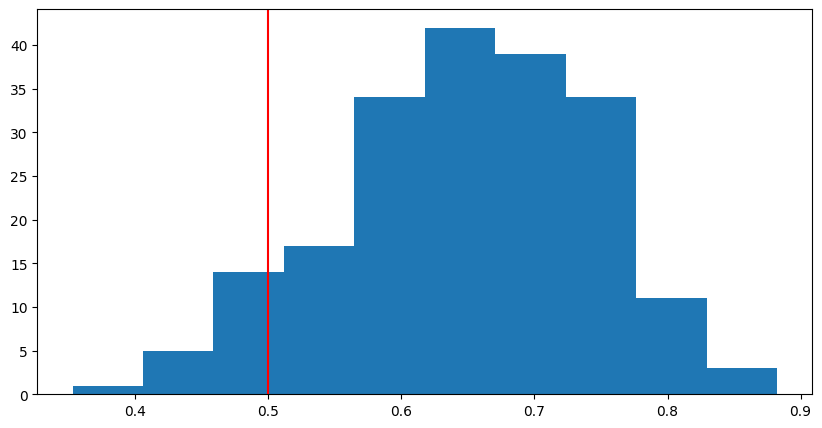

In [36]:
acuracis = []
for i in range(200):
    X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,razon=0.9)
    modelo_svm = svm.SVC(kernel='rbf',gamma=1e-7)
    modelo_svm.fit(X_entrenamiento,Y_entrenamiento)
    Y_predicho = modelo_svm.predict(X_test)
    acuracis.append(accuracy_score(Y_test,Y_predicho))

plt.figure(figsize = (10, 5))
plt.axvline(x = .5, color = 'r')
 
plt.hist(acuracis)

print(f'Acuracy de {round(np.mean(acuracis)*100,2)} ± {round(np.var(acuracis)*100,2)}')

In [ ]:
(otras cosas)

# Knn

In [ ]:
#Y_entrenamiento

In [ ]:
modelo_knn=KNeighborsClassifier(n_neighbors=4)
modelo_knn.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo_knn.predict(X_test)
print(classification_report(Y_test,Y_predicho))

In [ ]:
'''
vector = X_entrenamiento[4][:1200]
vector = np.reshape(vector, (int(len(vector)/3),3))
N = 3000
#print(vector)
vector = np.reshape([[i]*N for i in vector], (len(vector)*N,3))
imagen = np.reshape([vector]*N,(len(vector),N,3))
plt.imshow(imagen)
vector, vector.shape, imagen[0],imagen[1], imagen.shape
''';

In [ ]:
C_range = np.logspace(0.1, 5, 50)
gamma_range = np.logspace(0, 5, 50)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1312)
grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid=param_grid, cv=cv)
grid.fit(X, Y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

In [ ]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))

# Perdida Hinge

In [ ]:
modelo_hinge = SGDClassifier(loss="hinge", penalty="l2", max_iter=500)
modelo_hinge.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo_hinge.predict(X_test)
print(classification_report(Y_test,Y_predicho))



In [ ]:
modelo_hinge.predict(X_test[2].reshape(1, -1))


Como frente a SVM y KNN ofrece _mejores_ resltados, vamos a inspeccionar un poco más este algoritmo.

In [ ]:
parametros = {'loss':('hinge', 'squared_hinge', 'log_loss'), 'max_iter':[15, 20, 25, 30, 40, 50]}
modelo_hinge = SGDClassifier()
modelo_hinge = GridSearchCV(modelo_hinge, parametros)
modelo_hinge.fit(X_entrenamiento,Y_entrenamiento)

print("Mejores Hiperparámetros: ", modelo_hinge.best_params_)
modelo_hinge = SGDClassifier(loss=modelo_hinge.best_params_['loss'], penalty="l2", max_iter=modelo_hinge.best_params_['max_iter'])
modelo_hinge.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo_hinge.predict(X_test)
print(classification_report(Y_test,Y_predicho))

In [ ]:
modelo_hinge = SGDClassifier(loss="squared_hinge", penalty="l2", max_iter=50)
modelo_hinge.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo_hinge.predict(X_test)
print(classification_report(Y_test,Y_predicho))

# Ensembles

In [ ]:
modelo_boosting=GradientBoostingClassifier(n_estimators=50, learning_rate=.2, max_depth=50)
modelo_boosting.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo_boosting.predict(X_test)
print(classification_report(Y_test,Y_predicho))

# Selección de hiperparámetros

In [ ]:
parametros = {'loss':('hinge', 'squared_hinge', 'log_loss'), 'max_iter':[15, 20, 25, 30, 40, 50]}
validacionCruzada = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
busqueda = GridSearchCV(estimator=modelo_hinge, param_grid=parametros, n_jobs=-1,cv=validacionCruzada, scoring='f1_weighted')
resultados = busqueda.fit(X_entrenamiento, Y_entrenamiento)
# extract the best model and evaluate it
print("evaluando...")
modeloMejorado = resultados.best_estimator_
print("R2: {:.2f}".format(modeloMejorado.score(X_test, Y_test)))
Y_predicho = modeloMejorado.predict(X_test)
print(classification_report(Y_test,Y_predicho))

In [ ]:
plt.hist([len(i) for i in X],bins=25);

In [ ]:
len(X[0])/3

In [ ]:

# Prints list of random items of given length
list1 = [1, 2, 3, 4, 5] 

print(sample(list1,8))

In [ ]:
l = [2,4,6,7,5,3,2,5,3,6]
del l[0], l[1]
l

In [ ]:
list(reversed(list(enumerate(l))))